In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.insert(0, '/content/drive/MyDrive/Step3')

import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

from utils import display_prediction, decode_segmap
from Cityscapes import Cityscapes
from bisenetv2 import BiSeNetV2
from bisenetv2 import BiSeNetV2
from deeplabv3 import deeplabv3_mobilenetv2

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Running on {DEVICE}')

NUM_CLASSES = 19    

BATCH_SIZE = 4       # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 0.05            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 8       # Total number of training epochs (iterations over dataset)
NUM_ROUNDS = 8
NUM_CLIENTS = 10
STEP_SIZE = 25        # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1           # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 40

RESIZED_H = 512
RESIZED_W = 1024

MODE = 'TRAIN'       #TRAIN or LOAD_AND_TRAIN or LOAD
MODEL_PATH = '/content/drive/My Drive/Step3/a.tar' #File to save the model in

Running on cuda


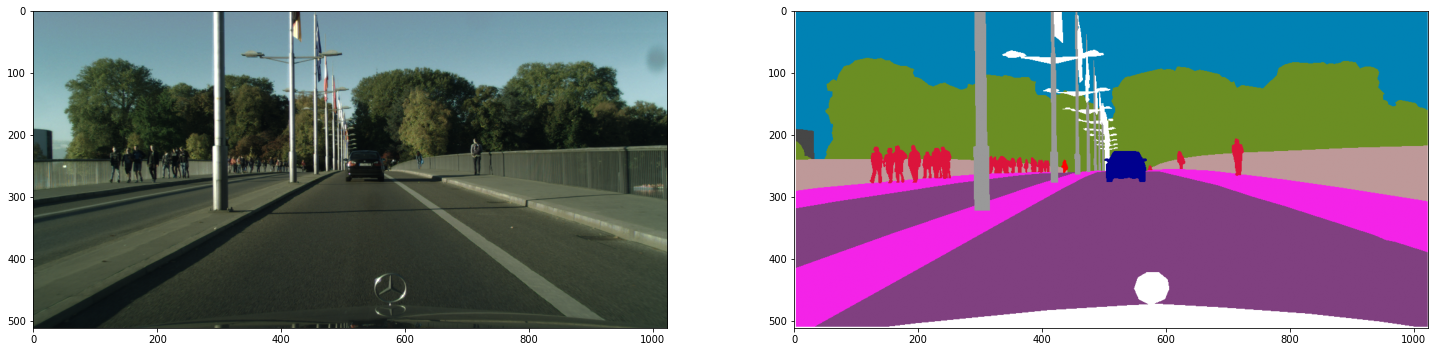

In [4]:
mean = [0.3257, 0.3690, 0.3223]
std = [0.2112, 0.2148, 0.2115]
normalizer = transforms.Normalize(mean=mean, std=std)
resizer_bicubic = transforms.Resize((RESIZED_H, RESIZED_W), interpolation=InterpolationMode.BICUBIC)
resizer_nearest = transforms.Resize((RESIZED_H, RESIZED_W), interpolation=InterpolationMode.NEAREST)

train_transform = transforms.Compose([resizer_bicubic])
eval_transform = transforms.Compose([resizer_bicubic])
target_transform = transforms.Compose([resizer_nearest])

train_dataset = Cityscapes('drive/MyDrive/', partition_type=('B', 'uniform'), split='train', transform=train_transform, target_transform=target_transform)
test_dataset = Cityscapes('drive/MyDrive/', partition_type=('B', 'uniform'), split='val', transform=eval_transform, target_transform=target_transform)

i, l = test_dataset.__getitem__(1)
fig = plt.figure(figsize=(25, 15))
fig.add_subplot(1, 2, 1)
plt.imshow(i.permute(1, 2, 0))
fig.add_subplot(1, 2, 2)
l = decode_segmap(l.squeeze())
plt.imshow(l)
plt.show()

In [5]:
!pip install torchmetrics
import torchmetrics
from torchmetrics.classification import MulticlassJaccardIndex
metric = MulticlassJaccardIndex(num_classes=NUM_CLASSES, ignore_index=255).to(DEVICE)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 35.5 MB/s eta 0:00:00


In [6]:
import copy
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import random

from torch.utils.data import DataLoader
from collections import defaultdict

class Client:
    def __init__(self, client_id, dataset, model, num_epochs=10, lr=0.05, batch_size=4, momentum=0.9, weight_decay=5e-5, device=None):
        self.id = client_id
        self.dataset = dataset
        self._model = model
        self.num_epochs = num_epochs
        self.lr = lr
        self.device = device
        self.batch_size = batch_size
        self.momentum = momentum
        self.weight_decay = weight_decay
        
        self.dataset.set_client(self.id) #IMPORTANT
        self.loader = DataLoader(self.dataset, batch_size=self.batch_size, drop_last=True)
        self.criterion = nn.CrossEntropyLoss(ignore_index=255)
        self.metric = MulticlassJaccardIndex(num_classes=19, ignore_index=255).to(self.device)
        self.optimizer = optim.SGD(self.model.parameters(), lr=self.lr, momentum=self.momentum, weight_decay=self.weight_decay)

    def run_epoch(self):
        loss_tot, miou, count = 0.0, 0.0, 0
        for cur_step, (images, labels) in enumerate(self.loader):
            images = images.to(self.device, dtype=torch.float32)
            labels = labels.squeeze().to(self.device, dtype=torch.long)

            self.optimizer.zero_grad()

            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            loss_tot += loss
            miou += self.metric(outputs, labels)
            count += 1

        return miou.item()/count, loss_tot.item()/count

    def generate_update(self):
        return copy.deepcopy(self.model.state_dict())

    def train(self):
        self.dataset.set_client(self.id) #IMPORTANT
        num_train_samples = len(self.dataset)

        self.model.train()

        print(f'Client #{self.id+1}:', end=' ')
        for epoch in range(self.num_epochs):
            miou, loss = self.run_epoch()
            print(f'{miou:.3f}', end=' ')
        print('')

        update = self.generate_update()
        return num_train_samples, update

    def __str__(self):
        return self.id

    @property
    def num_samples(self):
        return len(self.dataset)

    def len_loader(self):
        return len(self.loader)

    @property
    def model(self):
        return self._model

    @model.setter
    def model(self, model):
        self._model = model

In [7]:
import numpy as np
import torch
import copy
import torch.optim as optim

from collections import OrderedDict

class Server:
    def __init__(self, model):
        self.model = copy.deepcopy(model)
        self.model_params_dict = copy.deepcopy(self.model.state_dict())
        self.selected_clients = []
        self.updates = []
        self.optimizer = optim.SGD(params=self.model.parameters(), lr=1, momentum=0.9)
        self.total_grad = 0 
        self.round = 0

        self.history = {'val_miou': [0.0]} 

    def select_clients(self, my_round, possible_clients, num_clients=10):
        self.round = my_round
        num_clients = min(num_clients, len(possible_clients))
        np.random.seed(my_round)
        self.selected_clients = np.random.choice(possible_clients, num_clients, replace=False)

    def add_updates(self, num_samples, update):
        self.updates.append((num_samples, update))

    def _compute_client_delta(self, cmodel):
        delta = OrderedDict.fromkeys(cmodel.keys())
        for k, x, y in zip(self.model_params_dict.keys(), self.model_params_dict.values(), cmodel.values()):
            delta[k] = y - x if "running" not in k and "num_batches_tracked" not in k else y
        return delta

    def load_server_model_on_client(self, client):
        client.model.load_state_dict(self.model_params_dict)

    def train_model(self):
        self.optimizer.zero_grad()
        clients = self.selected_clients

        for i, c in enumerate(clients):
            self.load_server_model_on_client(c)
            num_samples, update = c.train()

            update = self._compute_client_delta(update)
            self.add_updates(num_samples=num_samples, update=update)

    def _server_opt(self, pseudo_gradient):

        for n, p in self.model.named_parameters():
            p.grad = -1.0 * pseudo_gradient[n]

        self.optimizer.step()

        bn_layers = OrderedDict(
            {k: v for k, v in pseudo_gradient.items() if "running" in k or "num_batches_tracked" in k})
        self.model.load_state_dict(bn_layers, strict=False)

    def _aggregation(self):
        total_weight = 0.
        base = OrderedDict()

        for (client_samples, client_model) in self.updates:
            total_weight += client_samples
            for key, value in client_model.items():
                if key in base:
                    base[key] += client_samples * value.type(torch.FloatTensor)
                else:
                    base[key] = client_samples * value.type(torch.FloatTensor)
        averaged_sol_n = copy.deepcopy(self.model_params_dict)
        for key, value in base.items():
            if total_weight != 0:
                averaged_sol_n[key] = value.to('cuda') / total_weight

        return averaged_sol_n

    def _get_model_total_grad(self):
        total_norm = 0
        for name, p in self.model.named_parameters():
            if p.requires_grad:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_grad = total_norm ** 0.5
        return total_grad

    def update_model(self):
        """FedAvg on the clients' updates for the current round.
        Weighted average of self.updates, where the weight is given by the number
        of samples seen by the corresponding client at training time.
        Saves the new central model in self.client_model and its state dictionary in self.model
        """
        averaged_sol_n = self._aggregation()

        self._server_opt(averaged_sol_n)
        self.total_grad = self._get_model_total_grad()
        self.model_params_dict = copy.deepcopy(self.model.state_dict())
        self.updates = []
    
    def test_model(self, test_dataloader, device='cuda'):
        self.model.eval()
        metric = MulticlassJaccardIndex(num_classes=19, ignore_index=255).to(device)

        miou = 0.0
        with torch.no_grad():
            for i, (images, labels) in enumerate(test_dataloader):
                images = images.to(device, dtype=torch.float32)
                labels = labels.squeeze().to(device, dtype=torch.long)

                outputs = self.model(images)
                miou += metric(outputs, labels)
        miou = miou.item()/len(test_dataloader)

        if miou > max(self.history['val_miou']): #If this is the best validation mIoU, save the model
            print(f'** Saving model with mIoU = {miou}')
            self.history['val_miou'].append(miou)
            torch.save({
                'model_state_dict': self.model.state_dict(),
                'optim_state_dict': self.optimizer.state_dict(),
                'round': self.round,
                'history': self.history,
        }, MODEL_PATH)
        self.history['val_miou'].append(miou)
        return miou
    
    def load_model(self, path):
        checkpoint = torch.load(MODEL_PATH)
        net.load_state_dict(checkpoint['model_state_dict'])
        #optimizer.load_state_dict(checkpoint['optim_state_dict'])
        round = checkpoint['round'] + 1
        self.history = checkpoint['history']
        mIoU = self.history['val_miou'][-1]
        print(f'Loading pre-trained model at round {round}, mIoU={mIoU}')
        return round, self.history
    
    def plot_history(self):
        plt.plot(self.history['val_miou'][1:], label='Validation mIoU')
        plt.legend()

Number of clients: 26
Client #3: 0.019 0.051 0.074 0.083 0.095 0.106 0.115 0.123 
Client #21: 0.018 0.041 0.074 0.096 0.105 0.108 0.121 0.127 
Client #15: 0.016 0.041 0.072 0.092 0.098 0.093 0.109 0.121 
Client #18: 0.016 0.038 0.064 0.077 0.085 0.094 0.099 0.108 
Client #6: 0.018 0.052 0.085 0.097 0.098 0.110 0.106 0.118 
Client #12: 0.015 0.037 0.062 0.078 0.084 0.090 0.102 0.109 
Client #23: 0.018 0.044 0.074 0.094 0.106 0.120 0.109 0.120 
Client #14: 0.017 0.041 0.069 0.090 0.092 0.100 0.099 0.111 
Client #19: 0.015 0.035 0.061 0.075 0.068 0.084 0.091 0.099 
Client #20: 0.016 0.037 0.061 0.084 0.094 0.109 0.112 0.118 
** Saving model with mIoU = 0.02165378275371733
ROUND 1: server mIoU = 0.022


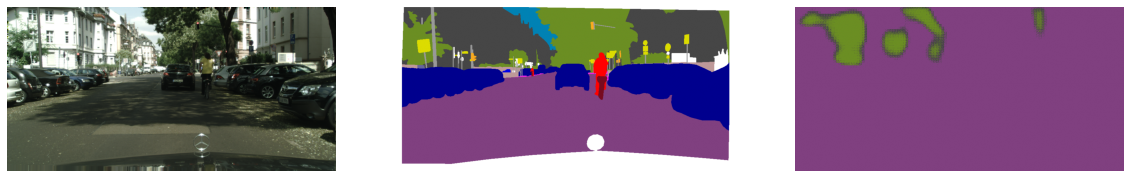

Client #19: 0.093 0.114 0.111 0.124 0.135 0.135 0.146 0.151 
Client #14: 0.103 0.116 0.127 0.133 0.132 0.138 0.140 0.146 
Client #18: 0.110 0.109 0.116 0.123 0.136 0.138 0.145 0.152 
Client #4: 0.097 0.104 0.114 0.122 0.127 0.132 0.136 0.136 
Client #23: 0.117 0.118 0.124 0.129 0.135 0.142 0.147 0.144 
Client #11: 0.091 0.108 0.111 0.103 0.120 0.128 0.134 0.135 
Client #20: 0.107 0.102 0.127 0.135 0.142 0.140 0.145 0.154 
Client #21: 0.114 0.122 0.136 0.146 0.158 0.164 0.171 0.174 
Client #5: 0.099 0.115 0.117 0.117 0.124 0.127 0.129 0.135 
Client #3: 0.106 0.112 0.119 0.124 0.135 0.135 0.145 0.153 
** Saving model with mIoU = 0.025086304498097255
ROUND 2: server mIoU = 0.025


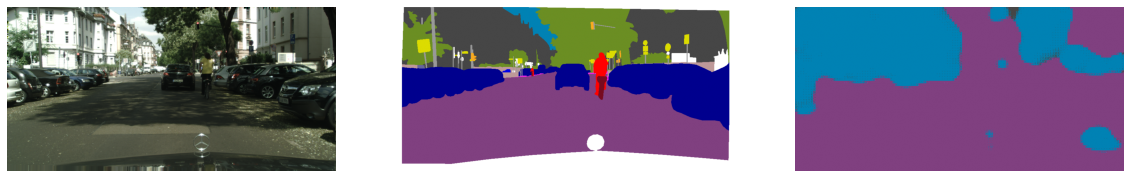

Client #25: 0.116 0.122 0.124 0.134 0.137 0.146 0.150 0.160 
Client #1: 0.122 0.122 0.128 0.133 0.138 0.142 0.146 0.147 
Client #10: 0.127 0.127 0.134 0.129 0.136 0.140 0.144 0.149 
Client #21: 0.129 0.136 0.151 0.163 0.171 0.181 0.189 0.194 
Client #17: 0.102 0.109 0.115 0.120 0.127 0.135 0.146 0.149 
Client #13: 0.124 0.131 0.136 0.141 0.149 0.158 0.163 0.169 
Client #7: 0.105 0.114 0.118 0.124 0.122 0.128 0.131 0.138 
Client #4: 0.116 0.126 0.122 0.129 0.139 0.145 0.152 0.153 
Client #18: 0.126 0.135 0.136 0.143 0.150 0.162 0.173 0.184 
Client #24: 0.124 0.133 0.137 0.136 0.147 0.146 0.160 0.159 
ROUND 3: server mIoU = 0.010


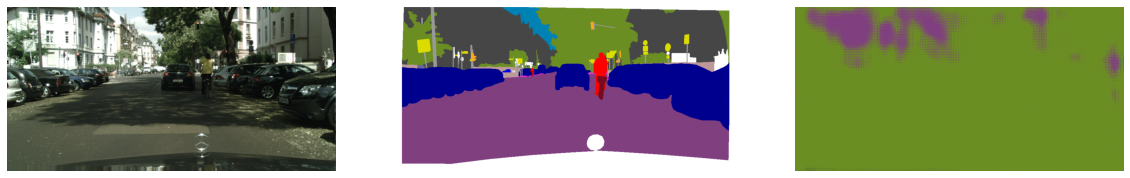

Client #19: 0.138 0.150 0.160 0.160 0.169 0.174 0.181 0.187 
Client #18: 0.144 0.150 0.161 0.175 0.189 0.193 0.205 0.211 
Client #13: 0.141 0.154 0.165 0.168 0.172 0.178 0.180 0.183 
Client #24: 0.140 0.151 0.144 0.155 0.164 0.171 0.172 0.181 
Client #16: 0.141 0.150 0.152 0.159 0.161 0.168 0.167 0.188 
Client #17: 0.124 0.128 0.133 0.143 0.146 0.158 0.162 0.166 
Client #14: 0.145 0.151 0.157 0.161 0.163 0.173 0.180 0.187 
Client #3: 0.137 0.151 0.157 0.162 0.169 0.174 0.182 0.187 
Client #2: 0.134 0.141 0.150 0.152 0.151 0.159 0.165 0.173 
Client #23: 0.148 0.154 0.159 0.162 0.165 0.169 0.171 0.173 
ROUND 4: server mIoU = 0.021


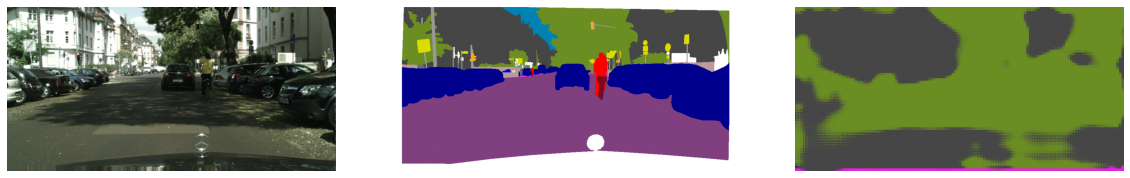

Client #25: 0.155 0.163 0.173 0.175 0.175 0.181 0.190 0.194 
Client #17: 0.161 0.159 0.167 0.168 0.174 0.180 0.188 0.194 
Client #23: 0.170 0.180 0.182 0.178 0.183 0.185 0.191 0.194 
Client #1: 0.161 0.165 0.170 0.170 0.174 0.184 0.187 0.193 
Client #4: 0.159 0.169 0.172 0.175 0.180 0.187 0.194 0.201 
Client #11: 0.153 0.151 0.160 0.163 0.164 0.169 0.173 0.180 
Client #13: 0.166 0.176 0.181 0.181 0.183 0.188 0.190 0.196 
Client #12: 0.151 0.166 0.173 0.178 0.183 0.189 0.195 0.199 
Client #7: 0.146 0.155 0.158 0.162 0.170 0.179 0.185 0.192 
Client #3: 0.167 0.175 0.181 0.182 0.188 0.188 0.193 0.192 
** Saving model with mIoU = 0.09495243193611266
ROUND 5: server mIoU = 0.095


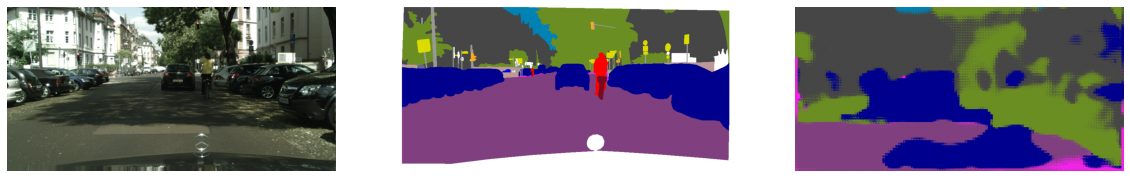

Client #23: 0.180 0.189 0.188 0.193 0.199 0.199 0.203 0.204 
Client #20: 0.180 0.194 0.202 0.207 0.212 0.220 0.223 0.227 
Client #3: 0.175 0.185 0.191 0.196 0.204 0.207 0.215 0.216 
Client #12: 0.168 0.181 0.188 0.197 0.201 0.210 0.216 0.220 
Client #21: 0.191 0.197 0.202 0.208 0.213 0.214 0.226 0.221 
Client #11: 0.166 0.171 0.181 0.189 0.195 0.201 0.207 0.209 
Client #19: 0.173 0.186 0.190 0.199 0.206 0.211 0.218 0.219 
Client #26: 0.163 0.174 0.181 0.187 0.192 0.197 0.204 0.204 
Client #24: 0.172 0.188 0.175 0.191 0.197 0.208 0.213 0.217 
Client #14: 0.181 0.191 0.194 0.201 0.206 0.212 0.218 0.221 
** Saving model with mIoU = 0.09559734283931672
ROUND 6: server mIoU = 0.096


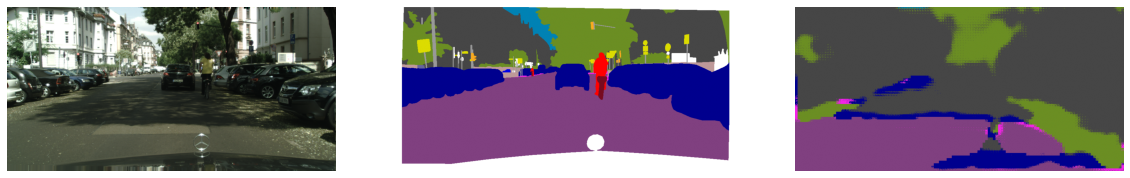

Client #1: 0.173 0.185 0.192 0.196 0.205 0.209 0.213 0.216 
Client #15: 0.184 0.199 0.204 0.208 0.214 0.219 0.222 0.224 
Client #8: 0.177 0.194 0.194 0.205 0.212 0.217 0.224 0.229 
Client #6: 0.182 0.194 0.200 0.206 0.215 0.219 0.224 0.226 
Client #24: 0.176 0.192 0.192 0.205 0.209 0.220 0.223 0.225 
Client #7: 0.162 0.173 0.184 0.192 0.196 0.201 0.212 0.217 
Client #13: 0.178 0.196 0.203 0.209 0.212 0.217 0.218 0.223 
Client #3: 0.188 0.203 0.211 0.215 0.218 0.222 0.224 0.228 
Client #9: 0.164 0.180 0.182 0.191 0.197 0.201 0.209 0.212 
Client #20: 0.192 0.208 0.217 0.223 0.228 0.233 0.235 0.238 
ROUND 7: server mIoU = 0.078


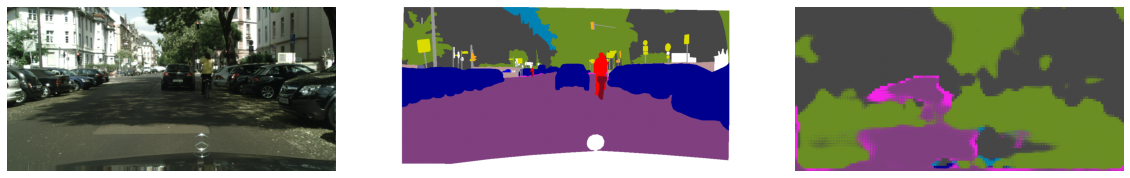

Client #13: 0.183 0.203 0.206 0.211 0.215 0.220 0.224 0.228 
Client #6: 0.192 0.203 0.206 0.219 0.225 0.231 0.232 0.236 
Client #2: 0.169 0.170 0.173 0.187 0.195 0.202 0.208 0.210 
Client #18: 0.181 0.199 0.210 0.219 0.225 0.229 0.234 0.239 
Client #12: 0.167 0.190 0.208 0.212 0.220 0.224 0.227 0.233 
Client #10: 0.183 0.182 0.191 0.197 0.199 0.210 0.215 0.216 
Client #3: 0.193 0.205 0.214 0.217 0.221 0.226 0.228 0.232 
Client #24: 0.184 0.200 0.200 0.215 0.221 0.226 0.229 0.234 
Client #26: 0.187 0.202 0.207 0.217 0.220 0.224 0.231 0.231 
Client #14: 0.203 0.217 0.220 0.225 0.228 0.230 0.234 0.236 
** Saving model with mIoU = 0.11856256969391353
ROUND 8: server mIoU = 0.119


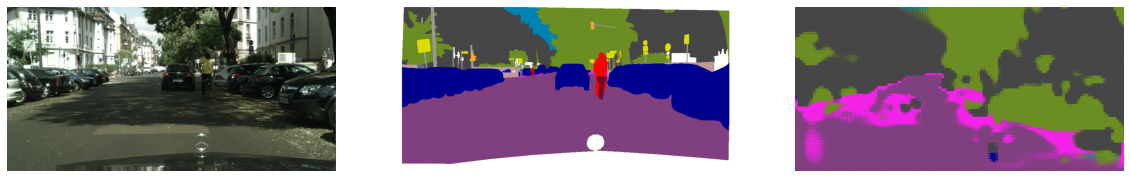

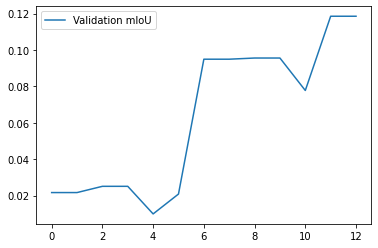

In [8]:
net = BiSeNetV2(NUM_CLASSES, output_aux=False, pretrained=False)
#net = deeplabv3_mobilenetv2(num_classes=19, in_channels=3)
net = net.to(DEVICE)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

num_clients = train_dataset.get_num_clients()
print(f'Number of clients: {num_clients}')

clients = []

for i in range(num_clients):
    c = Client(i, train_dataset, net, num_epochs=NUM_EPOCHS, lr=LR, batch_size=BATCH_SIZE, momentum=0.9, weight_decay=5e-5, device=DEVICE)
    clients.append(c)

server = Server(net)

if MODE == 'LOAD_AND_TRAIN':
    server.load_model(MODEL_PATH)

for r in range(NUM_ROUNDS):
    server.select_clients(r, clients, num_clients=NUM_CLIENTS)
    server.train_model()
    server.update_model()
    miou = server.test_model(test_loader, DEVICE)
    print(f'ROUND {r+1}: server mIoU = {miou:.3f}')
    display_prediction(server.model, test_dataset, random=False)
server.plot_history()

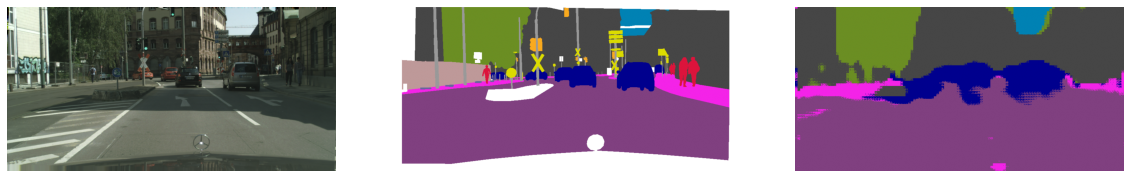

In [9]:
display_prediction(net, test_dataset, random=True)